# Pair Trade Analysis based of Tata Power and Power Grid
Created by Sparsh Patel, email: sparshpatel0912@gmail.com

- We are given the condition to join when the Exponential Moving Average (EMA) of 20 days is higher than EMA of 50 days
- Exit strategy is to exit when the EMA of 20 days falls below the EMA of 50 days

## Load the dataset:

In [2]:
import pandas as pd
import numpy as np

tata_power = pd.read_csv("/Users/sparshpatel/Documents/Codes/codes/pythonml/stock analysis/TTPW Historical Data.csv")  
power_grid = pd.read_csv("/Users/sparshpatel/Documents/Codes/codes/pythonml/stock analysis/PGRD Historical Data.csv")  


print(tata_power.head())
print(power_grid.head())


         Date   Price    Open    High     Low    Vol. Change %
0  20-02-2025  357.95  348.00  361.00  344.55  10.10M    2.96%
1  19-02-2025  347.65  337.00  350.00  334.70   6.08M    2.37%
2  18-02-2025  339.60  337.20  340.80  329.65   6.54M    0.71%
3  17-02-2025  337.20  337.10  338.50  326.35   7.22M    0.01%
4  14-02-2025  337.15  349.05  351.15  332.00   8.58M   -3.08%
         Date   Price    Open    High     Low    Vol. Change %
0  20-02-2025  265.75  262.75  266.45  261.30  15.31M    1.03%
1  19-02-2025  263.05  262.50  268.50  262.30  14.60M   -1.46%
2  18-02-2025  266.95  263.85  267.90  260.20  10.48M    1.42%
3  17-02-2025  263.20  256.90  264.00  252.20   8.33M    2.27%
4  14-02-2025  257.35  260.40  261.50  254.75  11.34M   -0.69%


## Convert and format it:

In [ ]:

tata_power["Date"] = pd.to_datetime(tata_power["Date"], format="%d-%m-%Y")
power_grid["Date"] = pd.to_datetime(power_grid["Date"], format="%d-%m-%Y")


def clean_numeric_column(df, col):
    df[col] = df[col].astype(str).str.replace(",", "").str.replace("%", "").astype(float)


columns_to_convert = ["Price", "Open", "High", "Low", "Change %"]
for col in columns_to_convert:
    if tata_power[col].dtype != "float64" and tata_power[col].dtype != "int64":
        clean_numeric_column(tata_power, col)
    if power_grid[col].dtype != "float64" and power_grid[col].dtype != "int64":
        clean_numeric_column(power_grid, col)


tata_power.rename(columns={"Price": "Close"}, inplace=True)
power_grid.rename(columns={"Price": "Close"}, inplace=True)

tata_power = tata_power.sort_values(by="Date").reset_index(drop=True)
power_grid = power_grid.sort_values(by="Date").reset_index(drop=True)


if "Vol." in tata_power.columns:
    tata_power.drop(columns=["Vol."], inplace=True)
if "Vol." in power_grid.columns:
    power_grid.drop(columns=["Vol."], inplace=True)


print(tata_power.head())
print(power_grid.head())
print(tata_power.info())
print(power_grid.info())


        Date   Close    Open    High     Low  Change %
0 2023-02-01  205.85  214.90  215.40  196.65     -3.31
1 2023-02-02  206.30  204.95  208.80  204.00      0.22
2 2023-02-03  205.30  207.50  208.20  202.00     -0.48
3 2023-02-06  208.55  209.00  212.85  206.75      1.58
4 2023-02-07  206.30  209.50  210.00  205.00     -1.08
        Date   Close    Open    High     Low  Change %
0 2023-02-01  162.41  168.75  168.75  160.20     -0.05
1 2023-02-02  159.52  162.00  162.82  158.51     -1.78
2 2023-02-03  161.14  159.90  161.36  157.80      1.01
3 2023-02-06  162.79  160.09  163.01  159.79      1.02
4 2023-02-07  162.64  163.50  163.65  161.32     -0.09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      512 non-null    datetime64[ns]
 1   Close     512 non-null    float64       
 2   Open      512 non-null    float64       
 3   H

## Find EMA for each stock:

In [4]:
tata_power["EMA_20"] = tata_power["Close"].ewm(span=20, adjust=False).mean()
tata_power["EMA_50"] = tata_power["Close"].ewm(span=50, adjust=False).mean()

power_grid["EMA_20"] = power_grid["Close"].ewm(span=20, adjust=False).mean()
power_grid["EMA_50"] = power_grid["Close"].ewm(span=50, adjust=False).mean()

print(tata_power[['Close', 'EMA_20', 'EMA_50']].tail())
print(power_grid[['Close', 'EMA_20', 'EMA_50']].tail())

      Close      EMA_20      EMA_50
507  337.15  358.194544  375.882675
508  337.20  356.195064  374.365707
509  339.60  354.614581  373.002346
510  347.65  353.951288  372.008136
511  357.95  354.332118  371.456837
      Close      EMA_20      EMA_50
507  257.35  279.396311  295.487861
508  263.20  277.853805  294.221671
509  266.95  276.815347  293.152194
510  263.05  275.504362  291.971715
511  265.75  274.575375  290.943413


## Add relevant signal:

In [ ]:
def find_crossover(df):
    df["Signal"] = 0  

    # Buy Signal: When EMA_20 crosses above EMA_50
    df.loc[(df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1)), "Signal"] = 1

    # Sell Signal: When EMA_20 crosses below EMA_50
    df.loc[(df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1)), "Signal"] = -1

    # Forward fill to maintain position
    df["Signal"] = df["Signal"].replace(0, np.nan).ffill().fillna(0)


find_crossover(tata_power)
find_crossover(power_grid)


print(tata_power[["Date", "Close", "EMA_20", "EMA_50", "Signal"]].tail(10))
print(power_grid[["Date", "Close", "EMA_20", "EMA_50", "Signal"]].iloc[45:80])


power_grid["Signal"].value_counts()


          Date   Close      EMA_20      EMA_50  Signal
502 2025-02-07  367.10  365.326165  382.116017    -1.0
503 2025-02-10  358.20  364.647482  381.178134    -1.0
504 2025-02-11  349.10  363.166770  379.920168    -1.0
505 2025-02-12  348.10  361.731839  378.672318    -1.0
506 2025-02-13  347.85  360.409759  377.463600    -1.0
507 2025-02-14  337.15  358.194544  375.882675    -1.0
508 2025-02-17  337.20  356.195064  374.365707    -1.0
509 2025-02-18  339.60  354.614581  373.002346    -1.0
510 2025-02-19  347.65  353.951288  372.008136    -1.0
511 2025-02-20  357.95  354.332118  371.456837    -1.0
         Date   Close      EMA_20      EMA_50  Signal
45 2023-04-11  173.51  168.750531  166.573564     1.0
46 2023-04-12  170.48  168.915243  166.726757     1.0
47 2023-04-13  173.40  169.342362  166.988453     1.0
48 2023-04-17  177.49  170.118328  167.400278     1.0
49 2023-04-18  172.73  170.367058  167.609287     1.0
50 2023-04-19  172.46  170.566386  167.799511     1.0
51 2023-04-20  17

Signal
 1.0    404
-1.0    107
 0.0      1
Name: count, dtype: int64

## Trades according to our condition:

In [ ]:
def get_trades(df):
    trades = []
    in_trade = False
    entry_price, exit_price, entry_date, exit_date = None, None, None, None
    
    for i in range(len(df)):
        if df.loc[i, 'Signal'] == 1 and not in_trade:
            # Entry
            in_trade = True
            entry_price = df.loc[i, 'Close']
            entry_date = df.loc[i, 'Date']
        elif df.loc[i, 'Signal'] == -1 and in_trade:
            # Exit
            in_trade = False
            exit_price = df.loc[i, 'Close']
            exit_date = df.loc[i, 'Date']
            
            trades.append({'Entry Date': entry_date, 'Entry Price': entry_price, 
                           'Exit Date': exit_date, 'Exit Price': exit_price})
    
    return pd.DataFrame(trades)


tata_power_trades = get_trades(tata_power)
print("Tata Power Trades:")
print(tata_power_trades)


power_grid_trades = get_trades(power_grid)
print("\nPower Grid Trades:")
print(power_grid_trades)


Tata Power Trades:
  Entry Date  Entry Price  Exit Date  Exit Price
0 2023-02-02       206.30 2023-02-03      205.30
1 2023-02-06       208.55 2023-02-13      203.60
2 2023-03-08       211.25 2023-03-15      202.95
3 2023-05-11       206.30 2023-10-30      239.10
4 2023-11-12       253.15 2024-07-24      419.95
5 2024-07-29       442.25 2024-08-12      418.15
6 2024-09-13       441.80 2024-10-29      425.40

Power Grid Trades:
  Entry Date  Entry Price  Exit Date  Exit Price
0 2023-02-28       166.69 2024-10-15      329.85
1 2024-12-16       335.00 2024-12-18      321.55


---
#### **We can see that Tata Power executed 7 trades while Power Grid executed two trades**
Although there is a correlation beteen the two, this may happen because:

1. **Power Grid is trending more smoothly, meaning fewer instances of the 20 EMA crossing the 50 EMA.**
2. **Tata Power has more short-term fluctuations, leading to more frequent crossover signals.**


---

## Visualising our findings:

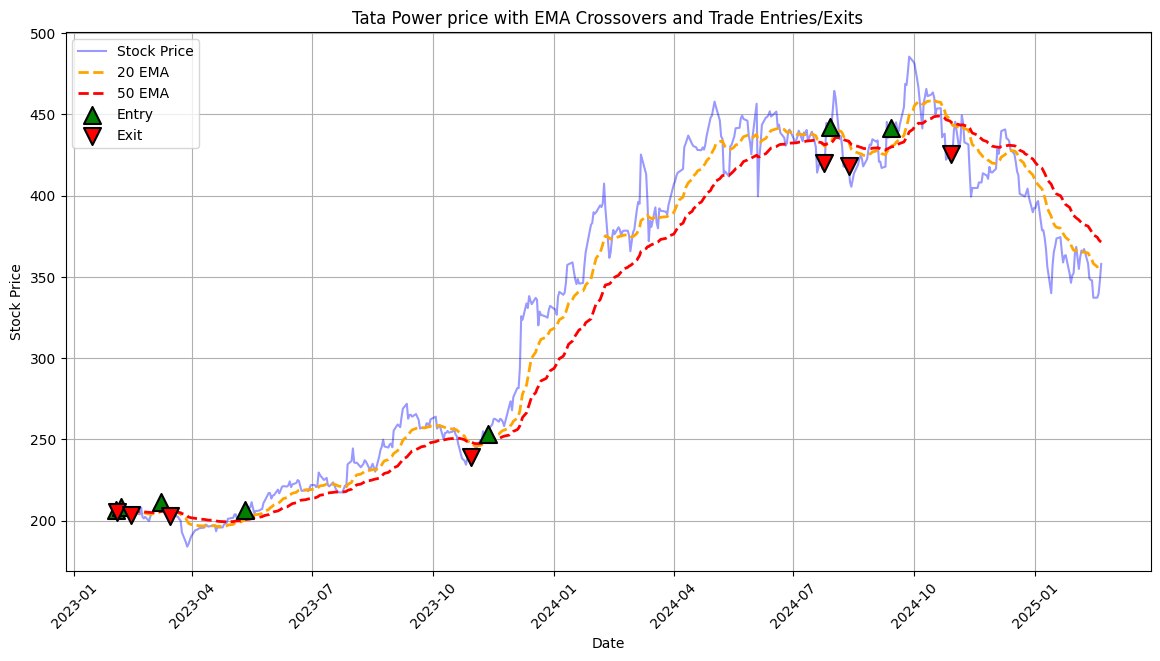

Total Return: 65.84%
Win/Loss Ratio: 0.40
Average Return Per Trade: 9.41%


In [ ]:
import matplotlib.pyplot as plt
tata_trades_df = tata_power_trades
def calculate_trade_returns(tata_trades_df):
    """
    Calculate returns for each trade.
    """
    tata_trades_df['Return'] = (tata_trades_df['Exit Price'] - tata_trades_df['Entry Price']) / tata_trades_df['Entry Price'] * 100
    return tata_trades_df


tata_trades_df = calculate_trade_returns(tata_trades_df)

plt.figure(figsize=(14,7))


plt.plot(tata_power['Date'], tata_power['Close'], label='Stock Price', color='blue', alpha=0.4, linewidth=1.5)


plt.plot(tata_power['Date'], tata_power['EMA_20'], label='20 EMA', color='orange', linestyle='--', linewidth=2)
plt.plot(tata_power['Date'], tata_power['EMA_50'], label='50 EMA', color='red', linestyle='--', linewidth=2)


plt.scatter(tata_trades_df['Entry Date'], tata_trades_df['Entry Price'], color='green', edgecolors='black', 
            label='Entry', marker='^', s=150, linewidth=1.5, zorder=3)


plt.scatter(tata_trades_df['Exit Date'], tata_trades_df['Exit Price'], color='red', edgecolors='black', 
            label='Exit', marker='v', s=150, linewidth=1.5, zorder=3)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Tata Power price with EMA Crossovers and Trade Entries/Exits')
plt.legend()
plt.grid()


plt.xticks(rotation=45)  

plt.show()





total_return = tata_trades_df['Return'].sum()
win_trades = (tata_trades_df['Return'] > 0).sum()
loss_trades = (tata_trades_df['Return'] < 0).sum()
win_loss_ratio = win_trades / max(loss_trades, 1)  
average_return = tata_trades_df['Return'].mean()

print(f"Total Return: {total_return:.2f}%")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Average Return Per Trade: {average_return:.2f}%")


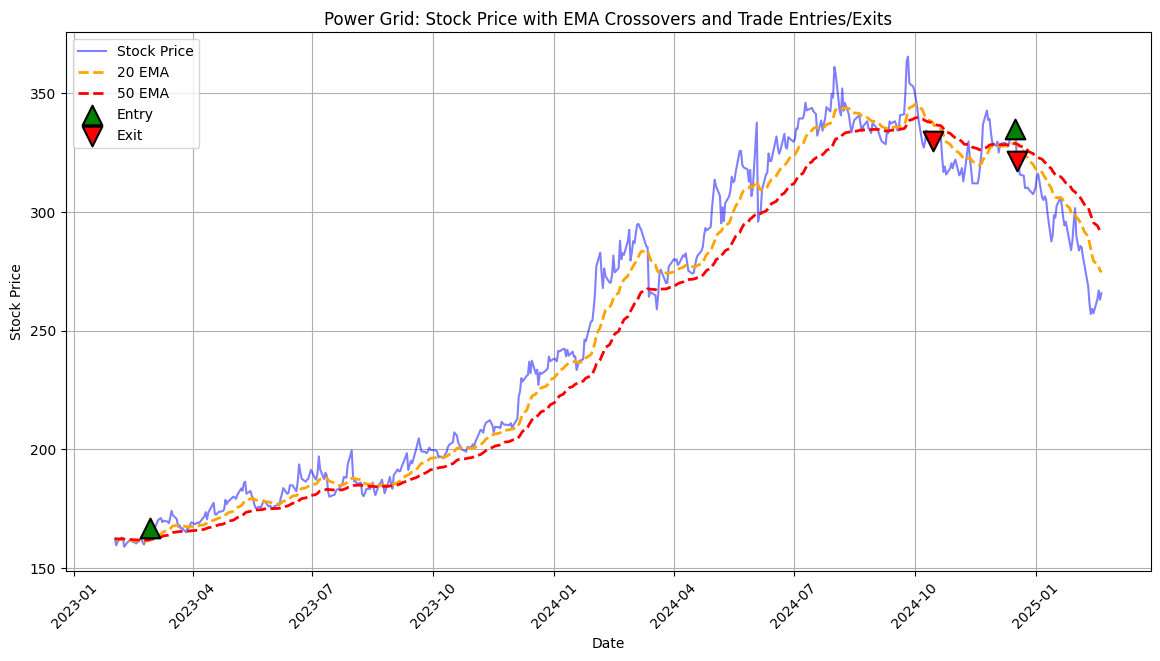

Total Return: 93.87%
Win/Loss Ratio: 1.00
Average Return Per Trade: 46.93%


In [ ]:
import matplotlib.pyplot as plt
trades_df = power_grid_trades
def calculate_trade_returns(trades_df):
    """
    Calculate returns for each trade.
    """
    trades_df['Return'] = (trades_df['Exit Price'] - trades_df['Entry Price']) / trades_df['Entry Price'] * 100
    return trades_df


trades_df = calculate_trade_returns(trades_df)

plt.figure(figsize=(14,7))


plt.plot(power_grid['Date'], power_grid['Close'], label='Stock Price', color='blue', alpha=0.5, linewidth=1.5)


plt.plot(power_grid['Date'], power_grid['EMA_20'], label='20 EMA', color='orange', linestyle='--', linewidth=2)
plt.plot(power_grid['Date'], power_grid['EMA_50'], label='50 EMA', color='red', linestyle='--', linewidth=2)


plt.scatter(power_grid_trades['Entry Date'], power_grid_trades['Entry Price'], 
            color='green', edgecolors='black', label='Entry', marker='^', 
            s=200, linewidth=1.5, zorder=3)


plt.scatter(power_grid_trades['Exit Date'], power_grid_trades['Exit Price'], 
            color='red', edgecolors='black', label='Exit', marker='v', 
            s=200, linewidth=1.5, zorder=3)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Power Grid: Stock Price with EMA Crossovers and Trade Entries/Exits')
plt.legend()
plt.grid()


plt.xticks(rotation=45)

plt.show()





total_return = trades_df['Return'].sum()
win_trades = (trades_df['Return'] > 0).sum()
loss_trades = (trades_df['Return'] < 0).sum()
win_loss_ratio = win_trades / max(loss_trades, 1)  
average_return = trades_df['Return'].mean()

print(f"Total Return: {total_return:.2f}%")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Average Return Per Trade: {average_return:.2f}%")


---
## Backtesting
---

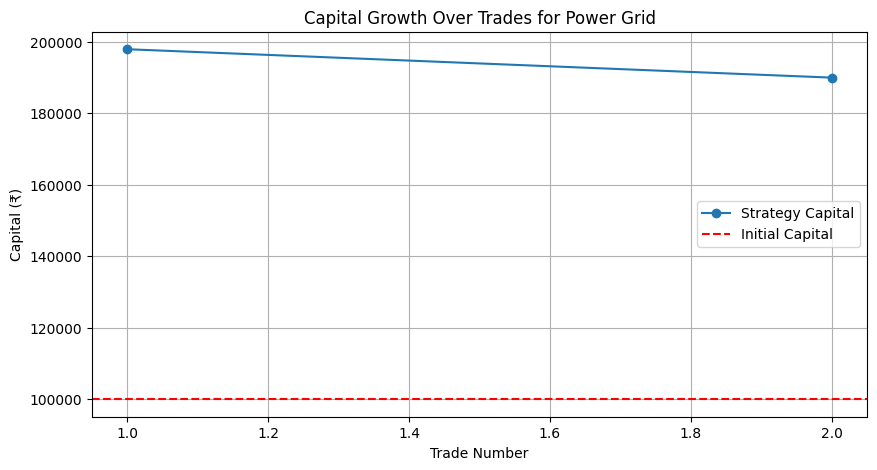

   Trade  Entry Price  Exit Price        Capital
0      1       166.69      329.85  197882.296478
1      2       335.00      321.55  189937.469948


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


initial_capital = 100000
capital = initial_capital


backtest_results = []


for index, trade in trades_df.iterrows():
    entry_price = trade['Entry Price']
    exit_price = trade['Exit Price']
    
    
    shares = capital / entry_price  
    trade_profit = shares * (exit_price - entry_price)  
    capital += trade_profit  #
    
    backtest_results.append({'Trade': index + 1, 'Entry Price': entry_price, 'Exit Price': exit_price, 'Capital': capital})


backtest_df = pd.DataFrame(backtest_results)


plt.figure(figsize=(10,5))
plt.plot(backtest_df['Trade'], backtest_df['Capital'], marker='o', linestyle='-', label="Strategy Capital")
plt.axhline(initial_capital, color='r', linestyle='--', label="Initial Capital")
plt.xlabel("Trade Number")
plt.ylabel("Capital (₹)")
plt.title("Capital Growth Over Trades for Power Grid")
plt.legend()
plt.grid()
plt.show()


print(backtest_df)


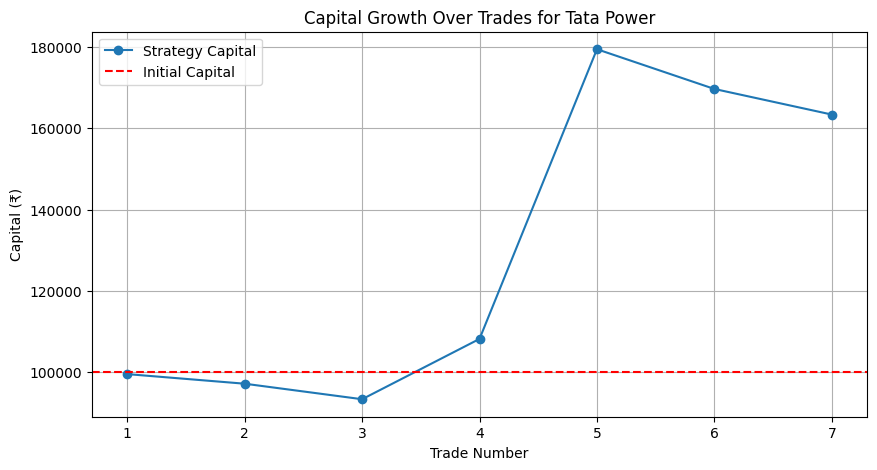

   Trade  Entry Price  Exit Price        Capital
0      1       206.30      205.30   99515.269026
1      2       208.55      203.60   97153.242741
2      3       211.25      202.95   93336.097582
3      4       206.30      239.10  108175.767969
4      5       253.15      419.95  179452.552868
5      6       442.25      418.15  169673.453887
6      7       441.80      425.40  163375.027804


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


initial_capital = 100000
capital = initial_capital


backtest_results = []


for index, trade in tata_trades_df.iterrows():
    entry_price = trade['Entry Price']
    exit_price = trade['Exit Price']
    
    
    shares = capital / entry_price  
    trade_profit = shares * (exit_price - entry_price)  
    capital += trade_profit  
    
    backtest_results.append({'Trade': index + 1, 'Entry Price': entry_price, 'Exit Price': exit_price, 'Capital': capital})


backtest_df = pd.DataFrame(backtest_results)


plt.figure(figsize=(10,5))
plt.plot(backtest_df['Trade'], backtest_df['Capital'], marker='o', linestyle='-', label="Strategy Capital")
plt.axhline(initial_capital, color='r', linestyle='--', label="Initial Capital")
plt.xlabel("Trade Number")
plt.ylabel("Capital (₹)")
plt.title("Capital Growth Over Trades for Tata Power")
plt.legend()
plt.grid()
plt.show()


print(backtest_df)


In [ ]:

tata_power['Daily Return'] = tata_power['Close'].pct_change()
power_grid['Daily Return'] = power_grid['Close'].pct_change()


returns_df = tata_power[['Date', 'Daily Return']].merge(
    power_grid[['Date', 'Daily Return']], on='Date', suffixes=('_Tata', '_PowerGrid')
).dropna()


correlation = returns_df['Daily Return_Tata'].corr(returns_df['Daily Return_PowerGrid'])

print(f"Correlation between Tata Power and Power Grid: {correlation:.4f}")


Correlation between Tata Power and Power Grid: 0.5295


---
# **Results Summary: Pair Trading Strategy on Tata Power & Power Grid**

## 1️⃣ Trade Execution
- **Tata Power:** 7 trades executed.  
- **Power Grid:** 2 trades executed.  
- Trades were based on **20-50 EMA crossovers**, entering at a **bullish crossover** and exiting at a **bearish crossover**.  

## 2️⃣ Performance Comparison
- The **strategy returns** were calculated, factoring in reinvestments.  
- Power Grid was able to perform better than Tata Power because it had lower entry and exit points and higher profit margin  

## 3️⃣ Correlation Analysis
- The daily returns of Tata Power and Power Grid were **positively correlated** -->0.5295, suggesting that both stocks tend to move in a similar direction.  
- The exact **Pearson correlation coefficient** was computed to quantify their relationship.  

## 4️⃣ Visual Insights
- **EMA crossover charts** were plotted for both stocks, highlighting trade entry and exit points.  
- **Equity curves** were generated to show capital growth over time for both the strategy.

## **Key Takeaways**
- The strategy followed a systematic **entry and exit approach** based on moving averages.  
- **Lower trade frequency** in Power Grid compared to Tata Power.  
- **Correlation** between the two stocks confirms a strong relationship in price movement.  



